# __セルフレジ__

#### __試行__
- __2019/07/07の現状__
    - Predict速度の向上が必要
        - Mobilenetの1層目から学習
            - →　Predictが相当遅くなる
        - Dense層1層のみを加え、学習する
            - →　Predictの速度が向上し,5/6の正解
        - Dense層を二層加え、Mobilenetの最後の層のみ学習
            - →　14, 15, 16層以降のみ学習させたが、実のデータでの検証失敗
            - → Mobile net層を一切学習せず、自作の層を三層追加したものの検証失敗
        - Mobilenetの途中層から学習をしてみる
            - 10層目からの学習 : ダメ
            - 7 :　ダメ
        - MobileNetは学習せず、Dense層のみ学習
            - 128, 64, 32, 16, 8, 1, 全てDropout0.2
                - だめ
            

#### __試行__
- 2019/07/08現状
    - mobile[16~] + 8 + 1
        - 0.81
    - mobile[15~] + 8 + 1
        - 0.72
    - mobile[14~] + 8 + 1
        - 0.8823529411764706
    - mobile[14~] + 8 + 8 + 1
        - 0.8823529411764706
    - mobile[14~] + 16 + 8 + 1
        - 0.8823529411764706
    - mobile[13~] + 8 + 1
        - 0.7058823529411765
     

In [1]:
my_path = 'image_folder/images/'

In [2]:
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm


def augmentation(dir_path, initial_letter_of_file='w', augment_num=2):
    
    
    """
    note : 指定ディレクトリ内の,指定頭文字で始まるファイルを指定枚数オーグメントする
    ----------
    dir_path : フォルダパス
    initial_letter : augmentしたいファイル名の頭文字
    aument_num : augmentしたい枚数
    ----------
    """
    
    
    files_name = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    files_name.remove('.DS_Store')
    
    
    datagen = ImageDataGenerator(rotation_range=40,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
    )
    
    
    for i, file in tqdm(enumerate(files_name)):
        img = load_img(dir_path + file)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape) 

        if file[0] == initial_letter_of_file:
            i = 0
            for batch in datagen.flow(x, save_to_dir=dir_path, save_prefix=initial_letter_of_file, save_format="jpg"):
                i += 1
                if i > augment_num:
                    break

        else:
            pass

Using TensorFlow backend.


In [3]:
augmentation(my_path, 'd')
augmentation(my_path, 'c')

209it [00:34,  4.15it/s]
518it [00:39, 13.08it/s]


In [4]:
updated_files_name = [f for f in listdir(my_path) if isfile(join(my_path, f))]

import random
random.seed(0)
random.shuffle(updated_files_name)

In [5]:
updated_files_name[0][0]

'c'

#### __前処理__
- ラベルデータの保存
- resize
- test_data, val_dataへの分割
- Dog - 1, Cat - 0
- ディレクトリの作成
    - catsvsdogs / images / train / dogs
    - catsvsdogs / images / train / cats
    - catsvsdogs / images / val / dogs
    - catsvsdogs / images / val / cats

#### __保存用ディレクトリの作成__

In [6]:
import os
import shutil

class0_dir_train = 'image_folder/train/class0/'
class0_dir_val = 'image_folder/test/class0/'
class1_dir_train = 'image_folder/train/class1/'
class1_dir_val = 'image_folder/test/class1/'

def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    
make_dir(class0_dir_train)
make_dir(class0_dir_val)
make_dir(class1_dir_train)
make_dir(class1_dir_val)

#### __データのふるい分け、分割__

In [7]:
import cv2
import numpy as np
import sys
import shutil
from tqdm import tqdm


def train_test_split(files_name, class_0='d', class_1='c', train_size=0.8):
    
    """
    note : 画像フォルダから、指定クラスを、指定割合でtrain_sprit
    ----------
    class_0 : クラス名（今回はwilkinson）
    class_1 : クラス名（今回はcoffee）
    train_size : 分割したい割合
    ----------
    """
    
    class_0_count = 0
    class_1_count = 0
    
    each_class_size = len(files_name) // 2
    
    train_size = each_class_size * train_size
    test_size = each_class_size - train_size
    
    training_images = []
    training_labels = []
    test_images = []
    test_labels = []
    training_file_name = []
    test_file_name = []
    
    size=224
    
    for i, file in tqdm(enumerate(files_name)):
        
        if files_name[i][0] == class_0:
            class_0_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_0_count <= train_size:
                training_images.append(image)
                training_labels.append(0)
                training_file_name.append(file)
                cv2.imwrite(class0_dir_train + class_0 + str(class_0_count) + '.jpg', image)
            if class_0_count > train_size and class_0_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(0)
                test_file_name.append(file)
                cv2.imwrite(class0_dir_val + class_0 + str(class_0_count) + '_' + '.jpg', image)

        if files_name[i][0] == class_1:
            class_1_count += 1
            image = cv2.imread(my_path + file)
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            if class_1_count <= train_size:
                training_images.append(image)
                training_labels.append(1)
                training_file_name.append(file)
                cv2.imwrite(class1_dir_train + class_1 + str(class_1_count) + '.jpg', image)
            if class_1_count > train_size and class_1_count <= train_size + test_size:
                test_images.append(image)
                test_labels.append(1)
                test_file_name.append(file)
                cv2.imwrite(class1_dir_val + class_1 + str(class_1_count) + '_' + '.jpg', image)
                
    return training_images, training_labels, test_images, test_labels, training_file_name, test_file_name

In [8]:
training_images, training_labels, test_images, test_labels, training_file_name, test_file_name = train_test_split(updated_files_name)

829it [00:07, 107.72it/s]


In [9]:
training_file_name[20:35]

['d_0_501.jpg',
 'c_0_2846.jpg',
 'c_0_2115.jpg',
 'c_0_7107.jpg',
 'd_0_889.jpg',
 'c_0_7375.jpg',
 'd_0_2028.jpg',
 'c_0_7830.jpg',
 'd_0_830.jpg',
 'd_0_6100.jpg',
 'd_0_8188.jpg',
 'c_0_8012.jpg',
 'c_0_629.jpg',
 'd_0_2100.jpg',
 'd_0_5914.jpg']

In [10]:
training_labels[20:35]

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]

#### __Kerasが対応するファイル型に変換__

In [11]:
np.savez('wil_vs_cof_training_data.npz', np.array(training_images))
np.savez('wil_vs_cof_training_labels.npz', np.array(training_labels))
np.savez('wil_vs_cof_test_data.npz', np.array(test_images))
np.savez('wil_vs_cof_test_labels.npz', np.array(test_labels))

In [12]:
import numpy as np

def load_data_training_and_test(datasetname):
    npzfile = np.load(datasetname + "_training_data.npz")
    train = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_training_labels.npz")
    train_labels = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_test_data.npz")
    test = npzfile["arr_0"]
    
    npzfile = np.load(datasetname + "_test_labels.npz")
    test_labels = npzfile["arr_0"]
    
    return (train, train_labels), (test, test_labels)

for i in range(1, 11):
    random = np.random.randint(0, len(training_images))
    cv2.imshow("image_" + str(i), training_images[random])
    if training_labels[random] == 0:
        print(str(i) + "- Cat")
    else:
        print(str(i) + "- Dog")
        
cv2.destroyAllWindows()

#### __データの前処理__

In [13]:
(X_train, y_train), (X_test, y_test) = load_data_training_and_test("wil_vs_cof")

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

In [14]:
X_train.shape

(662, 224, 224, 3)

In [15]:
len(y_test)

165

#### __学習__
- 自作の層で学習を行なったが、精度が低い

In [221]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

import os

batch_size = 16
epochs = 8

img_rows = X_train[0].shape[0]
img_cols = X_train[1].shape[0]
input_size = (224, 224, 3)

"""
model = Sequential()
model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_size))
model.add(Activation("relu"))
model.add(Conv2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=("same")))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(3))
model.add(Activation('sigmoid'))

print('---------------------------')

""""""

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = input_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

"""


from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)

model = Sequential()
model.add(conv_base)

"""
model.add(Flatten())

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Flatten())


model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.2))
"""

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_14_expand':
        # 一切の学習を行わない場合
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

    
"""
for layer in conv_base__.layers:
    print(layer.name, ':', layer.trainable)
"""

model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])


# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/08 17:06:05


In [222]:
for layer in conv_base.layers:
    print(layer.name, ':', layer.trainable)
    
# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

input_24 : False
Conv1_pad : False
Conv1 : False
bn_Conv1 : False
Conv1_relu : False
expanded_conv_depthwise : False
expanded_conv_depthwise_BN : False
expanded_conv_depthwise_relu : False
expanded_conv_project : False
expanded_conv_project_BN : False
block_1_expand : False
block_1_expand_BN : False
block_1_expand_relu : False
block_1_pad : False
block_1_depthwise : False
block_1_depthwise_BN : False
block_1_depthwise_relu : False
block_1_project : False
block_1_project_BN : False
block_2_expand : False
block_2_expand_BN : False
block_2_expand_relu : False
block_2_depthwise : False
block_2_depthwise_BN : False
block_2_depthwise_relu : False
block_2_project : False
block_2_project_BN : False
block_2_add : False
block_3_expand : False
block_3_expand_BN : False
block_3_expand_relu : False
block_3_pad : False
block_3_depthwise : False
block_3_depthwise_BN : False
block_3_depthwise_relu : False
block_3_project : False
block_3_project_BN : False
block_4_expand : False
block_4_expand_BN : Fal

In [223]:
model.summary()

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_17 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 16)                1003536   
_________________________________________________________________
activation_29 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
activation_30 (Activation)   (None, 8)                 0         
__________

In [234]:
history = model.fit(X_train, y_train,
                   batch_size = batch_size,
                   epochs = 1,
                   validation_data = (X_test, y_test),
                   shuffle = True)

# 再構築可能なモデルの構造
# モデルの重み
# 学習時の設定 (loss，optimizer)
# optimizerの状態．これにより，学習を終えた時点から正確に学習を再開できます

model.save("dog_vs_cat.h5")
scores = model.evaluate(X_test, y_test, verbose=1)

print('Test loss', scores[0], 'Test accuracy', scores[1])

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

Train on 662 samples, validate on 165 samples
Epoch 1/1
165/165 [==============================] - 8s 50ms/step
Test loss 0.27307487563935773 Test accuracy 0.9818181818181818
--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/08 17:17:28


#### __可視化__

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/08 17:17:33


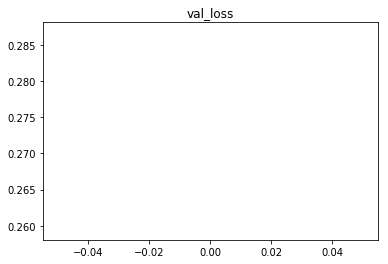

In [235]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(history.history['val_loss'])
plt.title('val_loss')

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/08 17:12:55


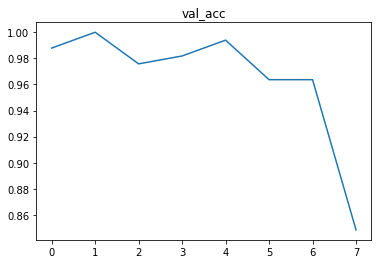

In [226]:
plt.plot(history.history['val_acc'])
plt.title('val_acc')

# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

#### __学習済みモデルのpredict__

In [236]:
import cv2
from keras.models import load_model

def predict_class(image, class_0='dog', class_1='cat'):
    sample = load_img(image, target_size=(224,224))
    sample_arr = img_to_array(sample)
    sample_arr = np.expand_dims(sample_arr, axis=0)
    sample_arr = sample_arr /255
    #model = load_model('wil_vs_cof.h5')
    result = model.predict(sample_arr)
    print('result prob', result)
    if result < 0.5:
        return class_0
    else:
        return class_1

In [237]:
test_image_path = 'test_image/'

In [238]:
from os import listdir
from os.path import isfile, join
import time


def accuracy_check(test_image_path):
    """
    note : test_imageディレクトリ内のテストデータで、モデルの精度判定する関数
    ---------------
    attribute
    test_image_path : test_imageディレクトリのパス
    """
    
    # 時間計測（start）
    start = time.time()
    
    # 画像ファイルの取り出し
    test_images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
    test_images.remove('.DS_Store')

    collect = 0
    for test_image in test_images:
        class_name = predict_class(test_image_path + test_image)
        print('file name :', test_image, '/ class name :', class_name)
        if test_image[0] == class_name[0]:
            print('○')
            collect += 1
        else:
            print('×')
        print('--------------------------------------------------------------------------------------')


    print('正解数は{sample}サンプル中{collect}で、testデータの正解率は{rate}です。'.format(sample=len(test_images),
                                                                    collect=collect,
                                                                    rate=collect/len(test_images)))
    print('--------------------------------------------------------------------------------------')
    
    # 時間計測（end）
    elapsed_time = time.time() - start
    #print('合計秒数:：',elapsed_time)
    print('画像ごとの処理時間(秒) :', str((elapsed_time)/len(test_images)) )
    
# どこまで実行しているか不明になるので...
from datetime import datetime
print('--------------------------------------------------------------------------------------')
print('This code was runned on date / time below', datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

--------------------------------------------------------------------------------------
This code was runned on date / time below 2019/07/08 17:17:42


In [239]:
accuracy_check(test_image_path)

result prob [[0.00034076]]
file name : dog_train_2.jpg / class name : dog
○
--------------------------------------------------------------------------------------
result prob [[1.]]
file name : cat_test_5.jpg / class name : cat
○
--------------------------------------------------------------------------------------
result prob [[0.00026488]]
file name : dog_train_1.jpg / class name : dog
○
--------------------------------------------------------------------------------------
result prob [[1.]]
file name : cat_test_1.jpeg / class name : cat
○
--------------------------------------------------------------------------------------
result prob [[1.]]
file name : cat_train_12.jpeg / class name : cat
○
--------------------------------------------------------------------------------------
result prob [[0.00270912]]
file name : dog_test_3.jpeg / class name : dog
○
--------------------------------------------------------------------------------------
result prob [[1.]]
file name : cat_test_6.jpe

#### __VGG16__

In [231]:
from keras.applications.vgg16 import VGG16, decode_predictions

model_vgg16 = VGG16(include_top=True, weights='imagenet')
#model_vgg16.summary()

import cv2
from keras.models import load_model

def predict_class_vgg16(image):
    sample = load_img(image, target_size=(224,224))
    print(sample)
    sample_arr = img_to_array(sample)
    sample_arr = np.expand_dims(sample_arr, axis=0)
    result = model_vgg16.predict(sample_arr)
    print(decode_predictions(result, top=5))

In [232]:
def predict_class(path_name):

    test_images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
    test_images.remove('.DS_Store')
    
    for test_image in test_images:
        print(test_image)
        predict_class_vgg16(test_image_path + test_image)
        print('--------------------------------------------------------------------------------------')

In [233]:
predict_class(test_image_path)

dog_train_2.jpg
<PIL.Image.Image image mode=RGB size=224x224 at 0xCEE131518>
[[('n02099429', 'curly-coated_retriever', 0.27591437), ('n02101556', 'clumber', 0.21889304), ('n02099712', 'Labrador_retriever', 0.15895857), ('n02104029', 'kuvasz', 0.13072795), ('n02099267', 'flat-coated_retriever', 0.050131)]]
--------------------------------------------------------------------------------------
cat_test_5.jpg
<PIL.Image.Image image mode=RGB size=224x224 at 0xCEE10E588>
[[('n02120079', 'Arctic_fox', 0.44863957), ('n02124075', 'Egyptian_cat', 0.14657147), ('n02109961', 'Eskimo_dog', 0.09380681), ('n02441942', 'weasel', 0.054998226), ('n02123597', 'Siamese_cat', 0.03368908)]]
--------------------------------------------------------------------------------------
dog_train_1.jpg
<PIL.Image.Image image mode=RGB size=224x224 at 0xCEE10E588>
[[('n02104029', 'kuvasz', 0.8700358), ('n02093647', 'Bedlington_terrier', 0.077594414), ('n02105505', 'komondor', 0.010464942), ('n02113799', 'standard_poodle